### Analysis of the optics measurement made on the MWPC and the BPMs
### 2nd measurement
## Focal point on BPM1

In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from pybt.tools.plotters import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def current(k, magnet_type, Brho):
    
    A_Q74L = [0.0,
    5.000978,
    10.000304,
    50.002003,
    100.001404,
    150.001373,
    200.00238,
    250.005432,
    299.993652,
    350.001648,
    399.995728,
    449.994446,
    499.997375,
    549.999878,
    599.994873,
    650.004211,
    666.999146,
    699.991455,
    749.998169,
    799.996643]
    
    T_Q74L = [0.0,
    0.2619,
    0.492968,
    2.358847,
    4.710821,
    7.068205,
    9.426532,
    11.780794,
    14.131984,
    16.4773,
    18.814776,
    21.133094,
    23.416058,
    25.617934,
    27.638804,
    29.43015,
    29.981004,
    30.987122,
    32.347211,
    33.545971]
    
    L_Q74L = 0.74
    
    A_Q120C = [0.00,
    50.00,
    100.00,
    150.00,
    200.00,
    250.00,
    300.00,
    350.00,
    400.00,
    450.00,
    500.00,
    550.00,
    600.00,
    650.00]
    
    T_Q120C = [0.00,
    2.05,
    4.12,
    6.19,
    8.26,
    10.33,
    12.39,
    14.43,
    16.44,
    18.36,
    20.14,
    21.74,
    23.01,
    24.07]
    
    L_Q120C = 1.2
    
    A_QFL = [0,
    94.15,
    145.76,
    197.97,
    250.74,
    300.18,
    350.7,
    402,
    451.15,
    502.09,
    551.47]
    
    T_QFL = [0,
    4.86,
    7.48,
    10.158,
    12.875,
    15.377,
    17.81,
    20.045,
    21.844,
    23.217,
    24.445]
    
    L_QFL = 1.2
    
    A_QFS = [0,
    98.95,
    147.71,
    197.23,
    249.64,
    301.81,
    351.91,
    400.77,
    454.51,
    506.28,
    555.25]
    
    T_QFS = [0,
    3.462,
    5.158,
    6.875,
    8.686,
    10.48,
    12.14,
    13.57,
    14.79,
    15.75,
    16.49]
    
    L_QFS = 0.8
    
    A_Q200L = [0.0,
    5.0,
    10.0,
    50.0,
    100.0,
    150.0,
    200.0,
    250.0,
    300.0,
    350.0,
    400.0,
    450.0,
    500.0,
    540.0,
    600.0,
    650.0,
    700.0,
    750.0,
    800.0,
    850.0]
    
    T_Q200L = [0.0,
    0.20,
    0.38,
    1.85,
    3.69,
    5.54,
    7.39,
    9.23,
    11.08,
    12.91,
    14.74,
    16.54,
    18.28,
    19.58,
    21.34,
    22.57,
    23.57,
    24.38,
    25.08,
    25.67]
    
    L_Q200L = 2.0
    
    if magnet_type == "Q74L":
        measured_currents = A_Q74L
        measured_int_gradient = T_Q74L
        length = L_Q74L
        
    if magnet_type == "Q120C":
        measured_currents = A_Q120C
        measured_int_gradient = T_Q120C
        length = L_Q120C
        
    if magnet_type == "QFL":
        measured_currents = A_QFL
        measured_int_gradient = T_QFL
        length = L_QFL
        
    if magnet_type == "QFS":
        measured_currents = A_QFS
        measured_int_gradient = T_QFS
        length = L_QFS
        
    if magnet_type == "Q200L":
        measured_currents = A_Q200L
        measured_int_gradient = T_Q200L
        length = L_Q200L
    
    int_grad = k*length * Brho
    current = np.interp(int_grad, measured_int_gradient, measured_currents)    
    
    return current

In [3]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov
def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

In [4]:
start_path = "/eos/user/e/eljohnso/SWAN_projects/quad-scan-east/"
end_path = "quad_scan_t8_bpms_data"
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [5]:
dirnames

['quad_scan_t8_bpms_2022_07_27_14h40m42s',
 'quad_scan_t8_bpms_2022_07_27_16h19m08s',
 'quad_scan_t8_bpms_2022_07_27_17h01m48s',
 'quad_scan_t8_bpms_2022_07_27_17h40m18s']

### Opening the first measurement which is a MWPC scan

In [6]:
subset_dirnames = [dirnames[1]]
subset_dirnames

['quad_scan_t8_bpms_2022_07_27_16h19m08s']

In [7]:
for dirname in subset_dirnames:
    print (dirname)
    infile = open(start_path+end_path+"/"+dirname+"/"+dirname+".p", 'rb')
    loaded_pickle = pickle.load(infile)

quad_scan_t8_bpms_2022_07_27_16h19m08s


#### Time

In [8]:
loaded_pickle[0][0]

datetime.datetime(2022, 7, 27, 16, 19, 13, 723707)

#### Measured pulse

In [9]:
loaded_pickle[1].keys()

dict_keys(['F61.QFN01/MEAS.PULSE#VALUE', 'F61.QDN02/MEAS.PULSE#VALUE', 'F61.QFN03/MEAS.PULSE#VALUE', 'F61.QDN04/MEAS.PULSE#VALUE', 'T8.QFN05/MEAS.PULSE#VALUE', 'T8.QDN06/MEAS.PULSE#VALUE', 'T8.QDN07/MEAS.PULSE#VALUE', 'T8.QFN08/MEAS.PULSE#VALUE'])

In [10]:
loaded_pickle[1]

{'F61.QFN01/MEAS.PULSE#VALUE': [693.6387939453125,
  693.6353759765625,
  693.642578125,
  693.632080078125,
  693.6466064453125,
  693.630126953125,
  693.6439819335938,
  693.638427734375,
  693.6392822265625,
  693.644287109375,
  693.636474609375,
  693.633056640625,
  693.6397705078125,
  693.6318359375,
  693.640380859375,
  693.6387329101562,
  693.6278686523438,
  693.6346435546875,
  693.635498046875,
  693.6416015625,
  693.6328735351562,
  693.638427734375,
  693.6407470703125,
  693.6207885742188,
  693.635498046875,
  693.64208984375,
  693.6348266601562,
  693.637939453125,
  693.6307373046875,
  693.633544921875,
  693.6258544921875,
  693.6365966796875,
  693.6343994140625,
  693.6263427734375,
  693.6328125,
  693.637451171875,
  693.6370849609375,
  693.631103515625,
  693.6367797851562,
  693.638671875,
  693.635009765625,
  693.6286010742188,
  693.6394653320312,
  693.6422729492188,
  693.6398315429688,
  693.6355590820312,
  693.6334838867188,
  693.639404296875,


#### K Func list F61

In [11]:
loaded_pickle[2].keys()

dict_keys(['logical.F61.QFN01/K_FUNC_LIST#value', 'logical.F61.QDN02/K_FUNC_LIST#value', 'logical.F61.QFN03/K_FUNC_LIST#value', 'logical.F61.QDN04/K_FUNC_LIST#value'])

In [12]:
loaded_pickle[2]['logical.F61.QFN01/K_FUNC_LIST#value'][0][0][1][0]

0.51826

#### Intensity in the PS

In [13]:
loaded_pickle[3][0]

19.748031616210938

#### I Func list

In [14]:
loaded_pickle[4].keys()

dict_keys(['logical.F61.QFN01/I_FUNC_LIST#value', 'logical.F61.QDN02/I_FUNC_LIST#value', 'logical.F61.QFN03/I_FUNC_LIST#value', 'logical.F61.QDN04/I_FUNC_LIST#value'])

#### OASIS current

In [15]:
loaded_pickle[5].keys()

dict_keys(['F61.QFN01/LOG.OASIS.I_MEAS#DATA', 'F61.QDN02/LOG.OASIS.I_MEAS#DATA', 'F61.QFN03/LOG.OASIS.I_MEAS#DATA', 'F61.QDN04/LOG.OASIS.I_MEAS#DATA', 'F61.QFN05/LOG.OASIS.I_MEAS#DATA', 'F61.QDN06/LOG.OASIS.I_MEAS#DATA', 'F61.QDN07/LOG.OASIS.I_MEAS#DATA', 'F61.QFN08/LOG.OASIS.I_MEAS#DATA'])

#### K Func list T8

In [16]:
loaded_pickle[6].keys()

dict_keys(['logical.T8.QFN05/K_FUNC_LIST#value', 'logical.T8.QDN06/K_FUNC_LIST#value', 'logical.T8.QDN07/K_FUNC_LIST#value', 'logical.T8.QFN08/K_FUNC_LIST#value'])

#### IRRAD BPM UCAP Positions

In [17]:
loaded_pickle[7].keys()

dict_keys(['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions', 'PS-LOG-BPM-IRRAD-UCAP_BPM_02/Positions', 'PS-LOG-BPM-IRRAD-UCAP_BPM_03/Positions', 'PS-LOG-BPM-IRRAD-UCAP_BPM_04/Positions'])

In [18]:
loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions'][0]["HSigma"]

0.10411437949032631

#### IRRAD BPM UCAP Profiles

In [19]:
loaded_pickle[8].keys()

dict_keys(['PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition', 'PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition', 'PS-LOG-BPM-IRRAD-UCAP_BPM_03/ProfilesAcquisition', 'PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition'])

In [20]:
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][0]["HRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][0]["HRawProfile"][1]

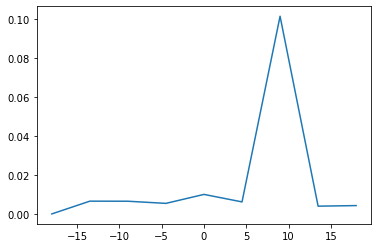

In [21]:
fig, ax = plt.subplots()
ax.plot(x,y)

#### BLMs

In [22]:
loaded_pickle[9].keys()

dict_keys(['F61.BLM008/Acquisition#lossBeamPresence', 'F61.BLM027/Acquisition#lossBeamPresence', 'F62.BLM002/Acquisition#lossBeamPresence', 'F63.BLM003/Acquisition#lossBeamPresence', 'T08.BLM006/Acquisition#lossBeamPresence', 'T08.BLM023/Acquisition#lossBeamPresence', 'T08.BLM045/Acquisition#lossBeamPresence', 'T08.BLM060/Acquisition#lossBeamPresence', 'T08.BLM067/Acquisition#lossBeamPresence'])

#### XSEC

In [23]:
loaded_pickle[10].keys()

dict_keys(['F61.XSEC023-I1/Acquisition#semNormData', 'F61.XSEC023-I2/Acquisition#semNormData', 'T08.XSEC070-I/Acquisition#semNormData', 'T08.XSEC094-I/Acquisition#semNormData'])

In [24]:
loaded_pickle[10]['F61.XSEC023-I1/Acquisition#semNormData'][0]

31474350000.0

#### MWPC UCAP

In [25]:
loaded_pickle[11].keys()

dict_keys(['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition', 'PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions', 'PS-LOG-MWPC-UCAP_IRRAD_2080/HighGainProfilesAcquisition', 'PS-LOG-MWPC-UCAP_IRRAD_2080/HighGainPositions'])

In [26]:
loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][0]["HSigma"]

34.25626962922058

sigma = 34.25626958151263
sigma = 6.645703322895944


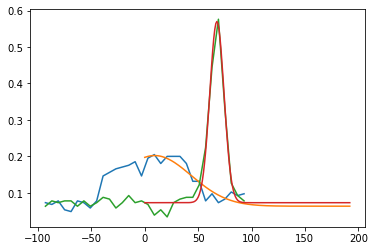

In [27]:
fig, ax = plt.subplots()
x = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["HRawProfile"][0]
y = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["HRawProfile"][1]
ax.plot(x,y)

poptH, pcovH = do_gaussian_fit(x, y)
x2 = np.linspace(0, 192, 200)
ax.plot(x2, gaussian_function(x2, poptH[0], poptH[1], poptH[2], poptH[3]))
print(f"sigma = {poptH[3]}")

x = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["VRawProfile"][0]
y = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][0]["VRawProfile"][1]
ax.plot(x,y)

poptH, pcovH = do_gaussian_fit(x, y)
x2 = np.linspace(0, 192, 200)
ax.plot(x2, gaussian_function(x2, poptH[0], poptH[1], poptH[2], poptH[3]))
print(f"sigma = {poptH[3]}")

In [28]:
df = pd.DataFrame(data = {})
                          
for j in range(len(loaded_pickle[0])):
    df2 = pd.DataFrame(data = {"time": loaded_pickle[0][j],
                               "intensity": [loaded_pickle[3][j]],
                               "meas_pulse_qfn01": loaded_pickle[1]['F61.QFN01/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn02": loaded_pickle[1]['F61.QDN02/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qfn03": loaded_pickle[1]['F61.QFN03/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn04": loaded_pickle[1]['F61.QDN04/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qfn05": loaded_pickle[1]['T8.QFN05/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn06": loaded_pickle[1]['T8.QDN06/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qdn07": loaded_pickle[1]['T8.QDN07/MEAS.PULSE#VALUE'][j],
                               "meas_pulse_qfn08": loaded_pickle[1]['T8.QFN08/MEAS.PULSE#VALUE'][j],
                               "k_qfn01": loaded_pickle[2]['logical.F61.QFN01/K_FUNC_LIST#value'][j][0][1][0],
                               "k_qdn02": loaded_pickle[2]["logical.F61.QDN02/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qfn03": loaded_pickle[2]["logical.F61.QFN03/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qdn04": loaded_pickle[2]['logical.F61.QDN04/K_FUNC_LIST#value'][j][0][1][0],
                               "k_qfn05": loaded_pickle[6]["logical.T8.QFN05/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qdn06": loaded_pickle[6]["logical.T8.QDN06/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qdn07": loaded_pickle[6]["logical.T8.QDN07/K_FUNC_LIST#value"][j][0][1][0],
                               "k_qfn08": loaded_pickle[6]["logical.T8.QFN08/K_FUNC_LIST#value"][j][0][1][0],
#                                "blm008": loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence'][j],
#                                "blm027": loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence'][j],
#                                "blm002": loaded_pickle[9]['F62.BLM002/Acquisition#lossBeamPresence'][j],
#                                "blm003": loaded_pickle[9]['F63.BLM003/Acquisition#lossBeamPresence'][j],
#                                "blm006": loaded_pickle[9]['T08.BLM006/Acquisition#lossBeamPresence'][j],
#                                "blm023": loaded_pickle[9]['T08.BLM023/Acquisition#lossBeamPresence'][j],
#                                "blm045": loaded_pickle[9]['T08.BLM045/Acquisition#lossBeamPresence'][j],
#                                "blm060": loaded_pickle[9]['T08.BLM060/Acquisition#lossBeamPresence'][j],
#                                "blm067": loaded_pickle[9]['T08.BLM067/Acquisition#lossBeamPresence'][j],
#                                "mwpc_HRawProfile": loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][j]["HRawProfile"],
                                "mwpc_HSigma": loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][j]["HSigma"],
                                "mwpc_VSigma": loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][j]["VSigma"],
                               "bpm01H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions'][j]["HSigma"],
                               "bpm01V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_01/Positions'][j]["VSigma"],
                               "bpm02H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_02/Positions'][j]["HSigma"],
                               "bpm02V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_02/Positions'][j]["VSigma"],
                               "bpm03H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_03/Positions'][j]["HSigma"],
                               "bpm03V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_03/Positions'][j]["VSigma"],
                               "bpm04H": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_04/Positions'][j]["HSigma"],
                               "bpm04V": loaded_pickle[7]['PS-LOG-BPM-IRRAD-UCAP_BPM_04/Positions'][j]["VSigma"],
                              })

    df = pd.concat([df,df2])
df.reset_index(drop=True, inplace=True)

In [29]:
df.head(1)

time  intensity  meas_pulse_qfn01  meas_pulse_qdn02  \
0 2022-07-27 16:19:13.723707  19.748032        693.638794        463.220459   

   meas_pulse_qfn03  meas_pulse_qdn04  meas_pulse_qfn05  meas_pulse_qdn06  \
0        371.433472          84.26857         86.693398        226.507736   

   meas_pulse_qdn07  meas_pulse_qfn08  ...  mwpc_HSigma  mwpc_VSigma  \
0        339.549194        334.902344  ...     34.25627     6.645703   

     bpm01H    bpm01V    bpm02H    bpm02V    bpm03H    bpm03V    bpm04H  \
0  0.104114  2.443394  5.086267  5.706541  2.616411  0.557427  1.196477   

     bpm04V  
0  0.671327  

[1 rows x 28 columns]

Text(0, 0.5, 'k')

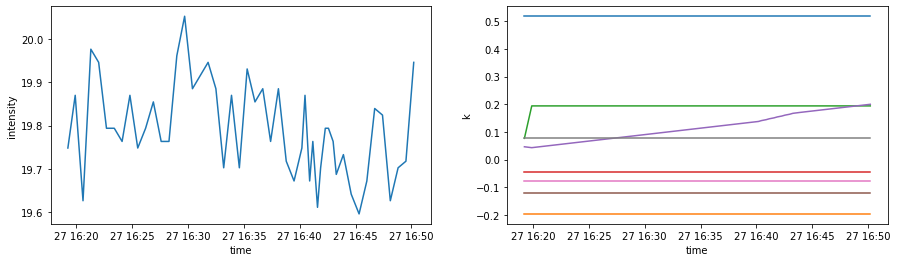

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(df.time, df.intensity)
ax[0].set_xlabel("time")
ax[0].set_ylabel("intensity")
ax[1].plot(df.time, df.k_qfn01)
ax[1].plot(df.time, df.k_qdn02)
ax[1].plot(df.time, df.k_qfn03)
ax[1].plot(df.time, df.k_qdn04)
ax[1].plot(df.time, df.k_qfn05)
ax[1].plot(df.time, df.k_qdn06)
ax[1].plot(df.time, df.k_qdn07)
ax[1].plot(df.time, df.k_qfn08)
ax[1].set_xlabel("time")
ax[1].set_ylabel("k")

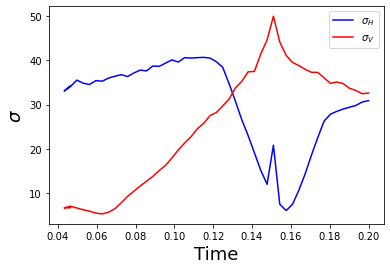

In [31]:
fig, ax = plt.subplots()
ax.plot(df.k_qfn05, df.mwpc_HSigma, color="b", label="$\sigma_{H}$")
ax.plot(df.k_qfn05, df.mwpc_VSigma, color="r", label="$\sigma_{V}$")
ax.set_xlabel("Time", fontsize=18)
ax.set_ylabel("$\sigma$", fontsize=18)
ax.legend()

In [32]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.xwcm103"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

(-0.1, 0.1)

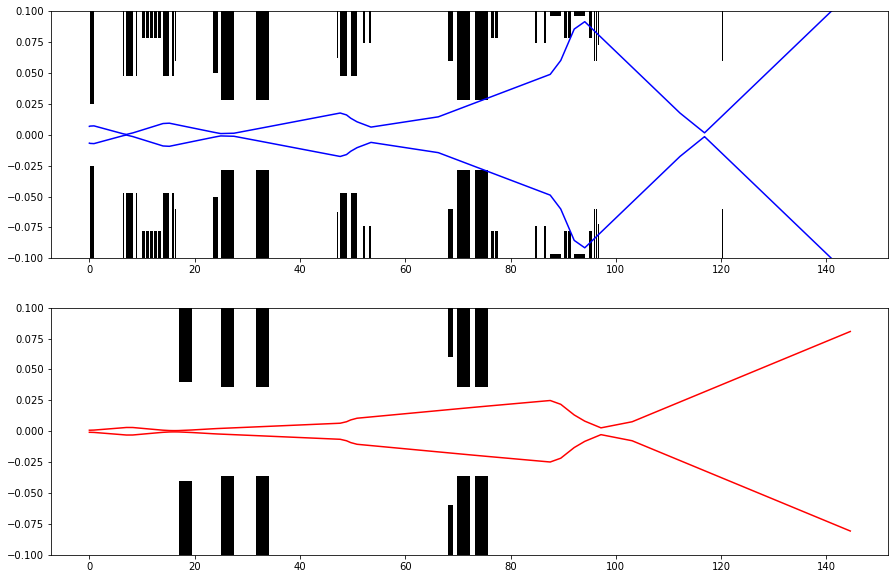

In [33]:
fig, ax = plt.subplots(2,1, figsize=(15, 10))
draw_aperture(ax[0], twiss_f61, 'aper_1')
ax[0].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), color ="b")
ax[0].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), color ="b")
ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r")
ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r")
draw_aperture(ax[1], twiss_f61, 'aper_2')
ax[0].set_ylim(-0.1, 0.1)
ax[1].set_ylim(-0.1, 0.1)

Text(0.5, 1.0, 'MWPC quadrupole scan')

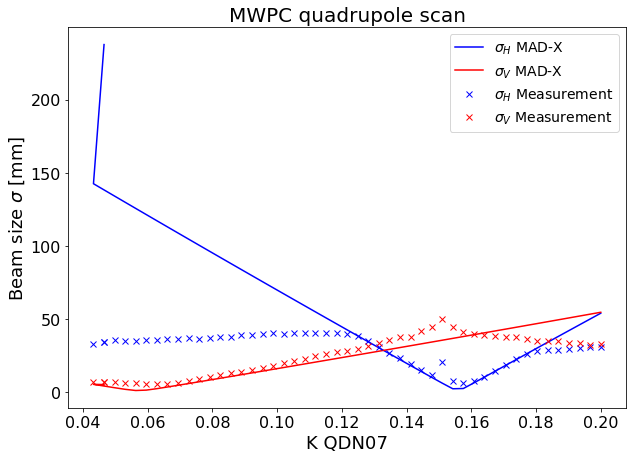

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qfn05, np.array(HSigma_madx)*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05, np.array(VSigma_madx)*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qfn05, df.mwpc_HSigma, color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qfn05, df.mwpc_VSigma, color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
# ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("MWPC quadrupole scan", fontsize=20)

### MWPC errorbars

In [35]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 2

for i in range(len(loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

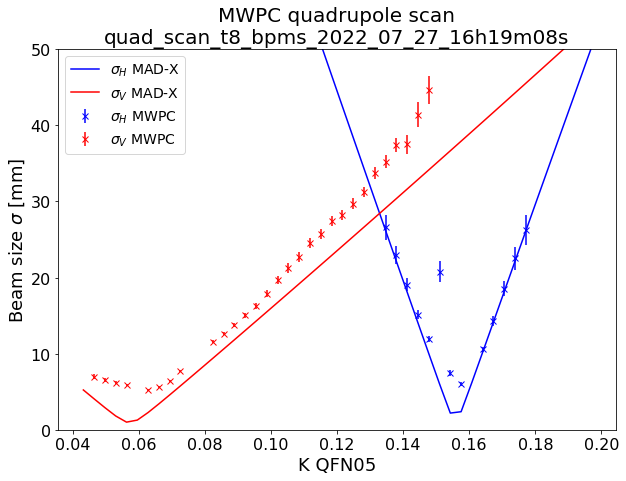

In [36]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qfn05[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.errorbar(df.k_qfn05[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ MWPC")
ax.errorbar(df.k_qfn05[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="r",marker="x", ls="", label="$\sigma_{V}$ MWPC")
# ax.set_xlim(0.04, 0.2)
ax.set_ylim(0,50)
ax.set_xlabel("K QFN05", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"MWPC quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/mwpc_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

/tmp/ipykernel_1456/1493656976.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


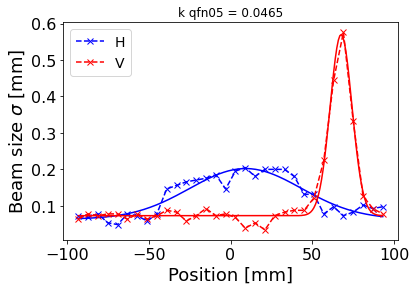

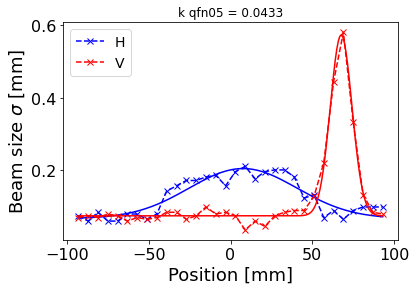

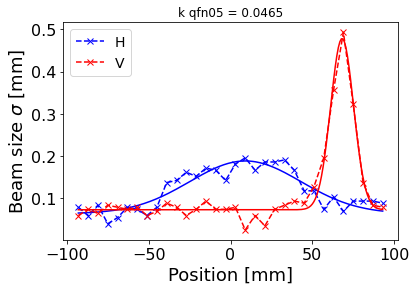

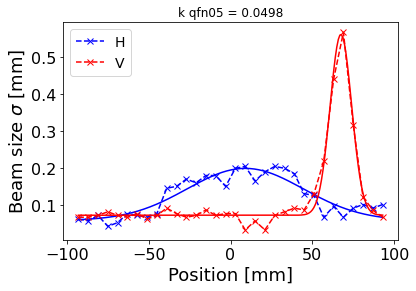

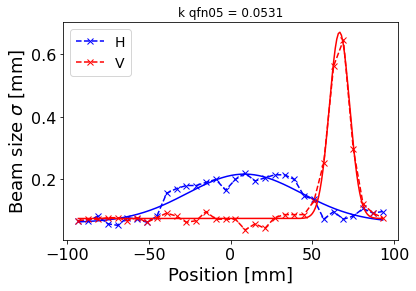

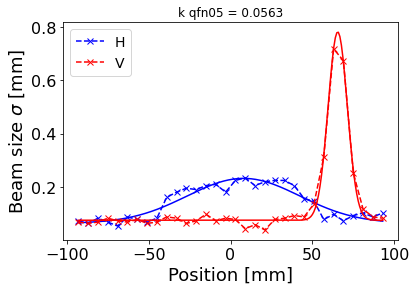

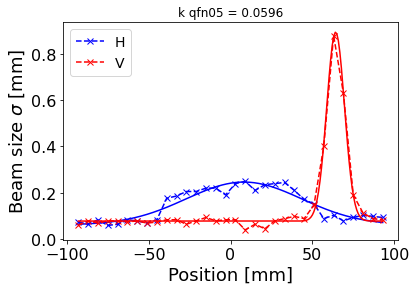

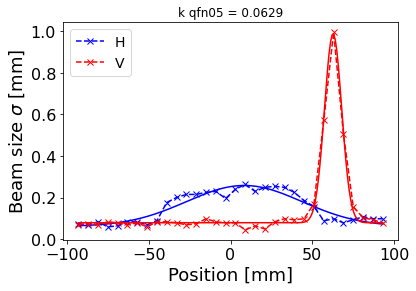

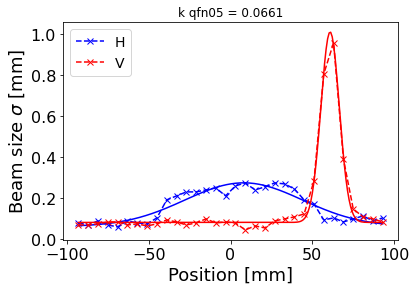

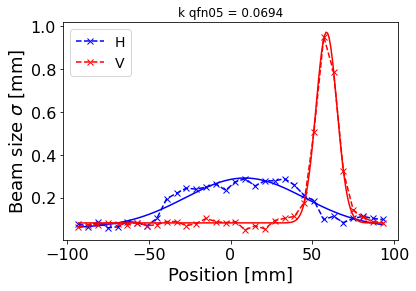

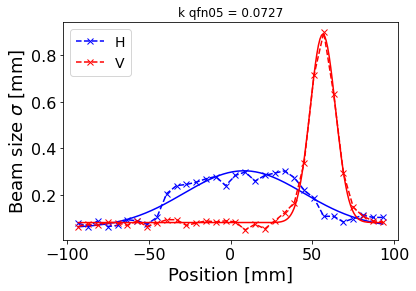

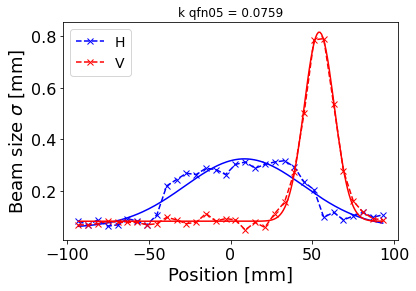

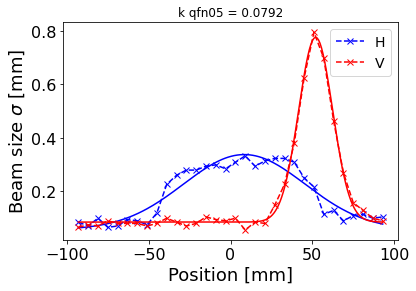

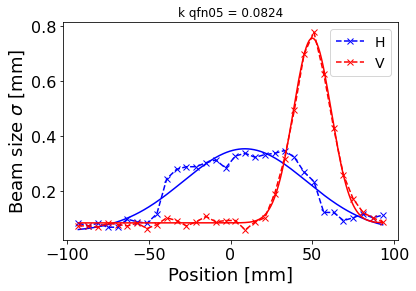

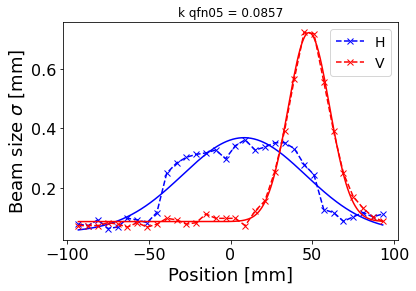

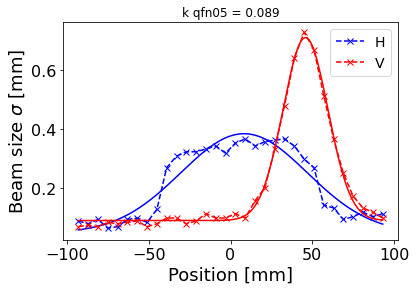

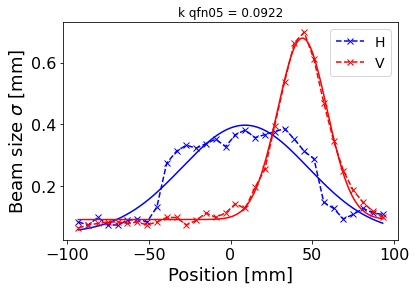

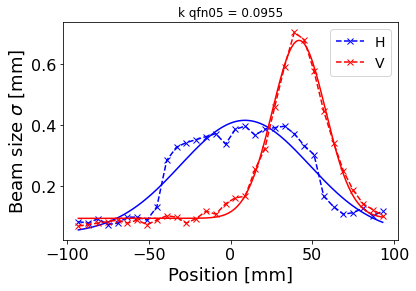

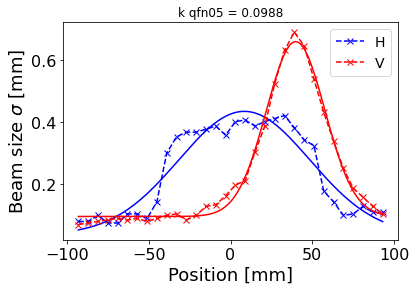

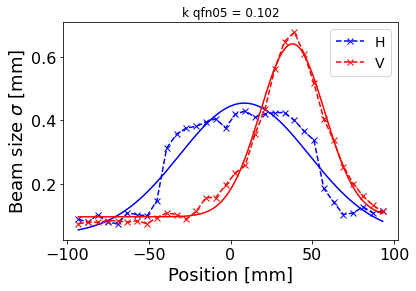

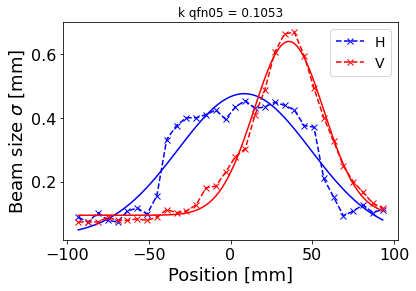

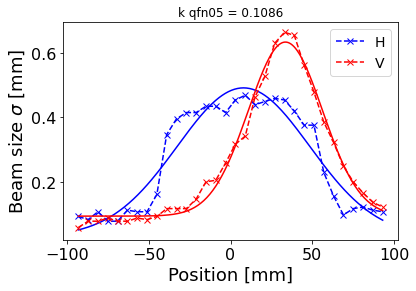

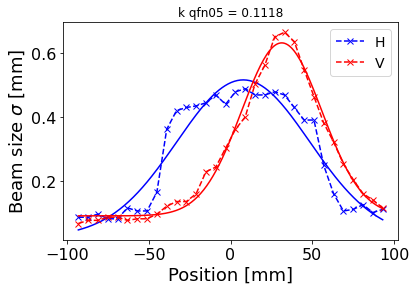

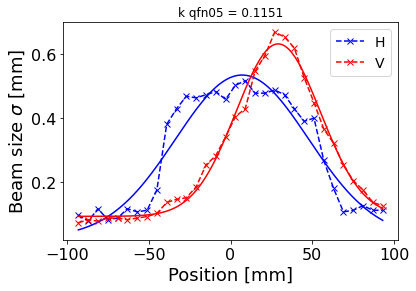

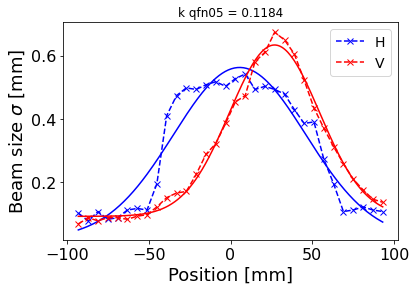

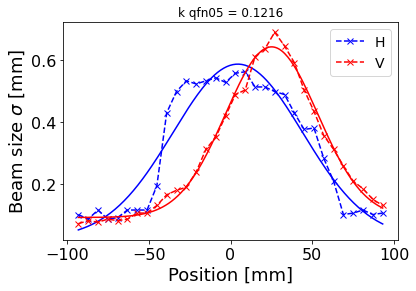

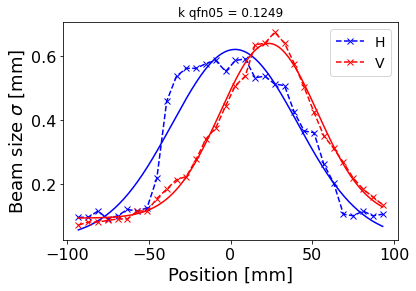

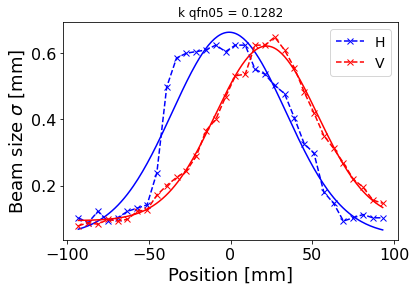

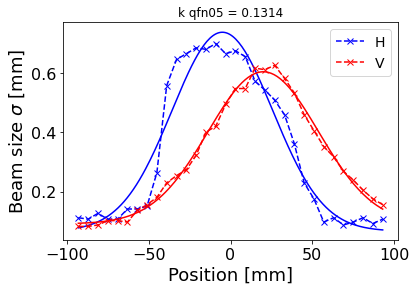

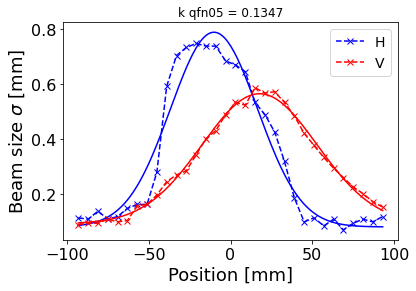

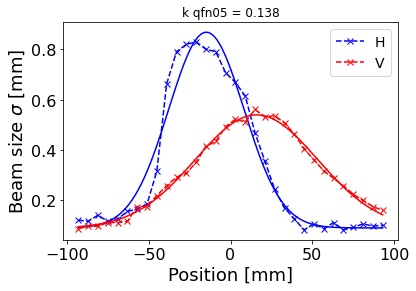

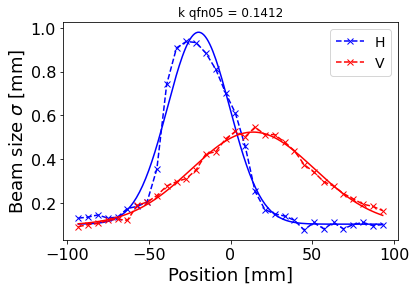

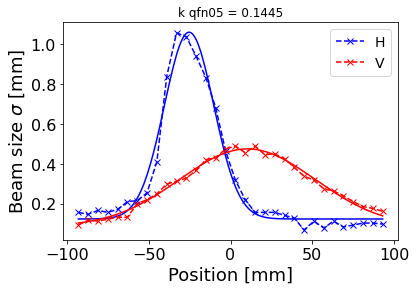

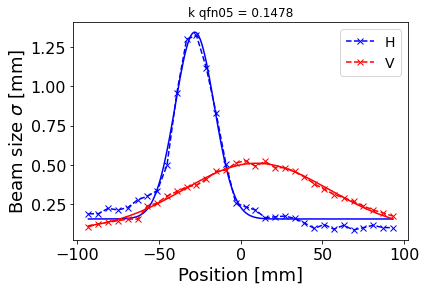

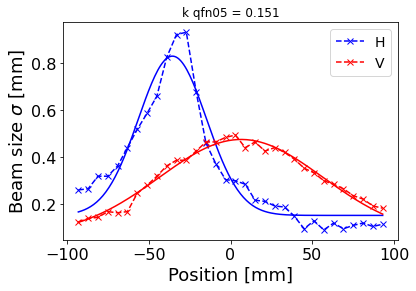

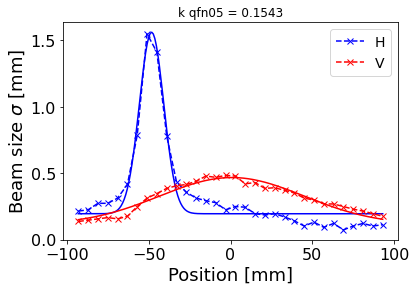

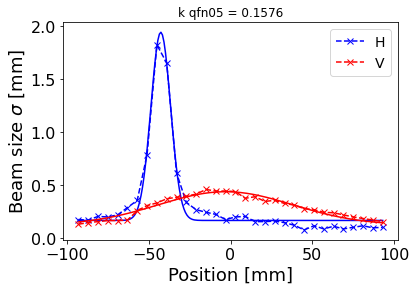

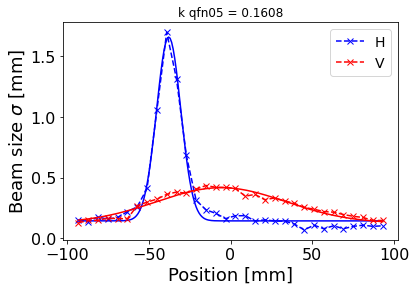

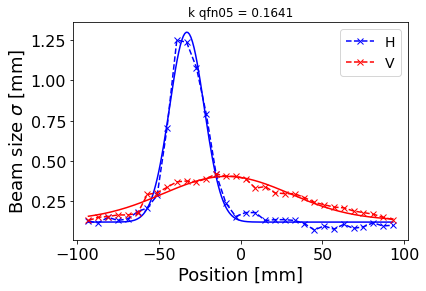

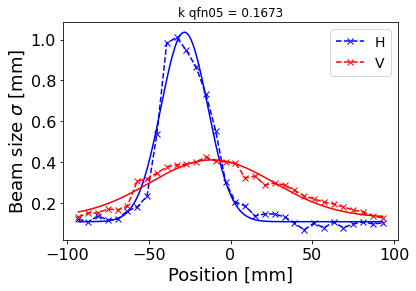

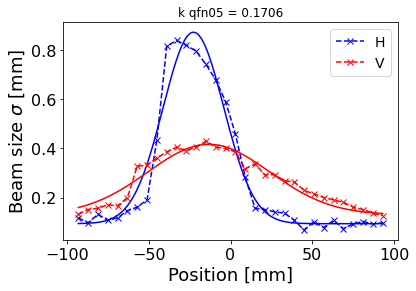

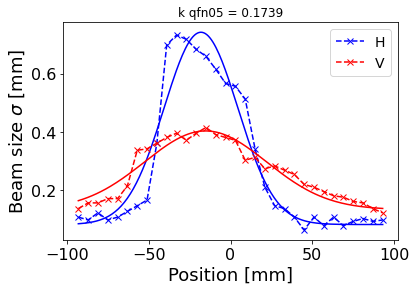

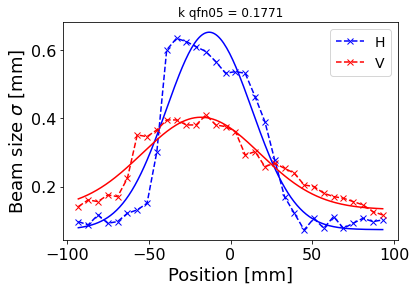

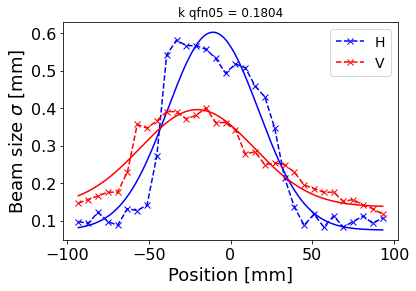

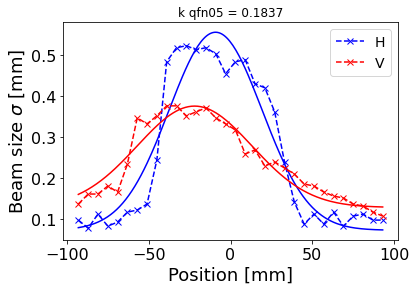

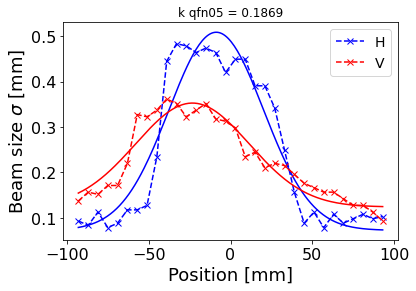

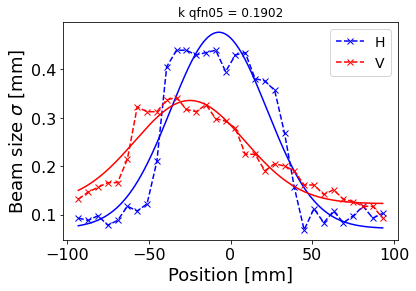

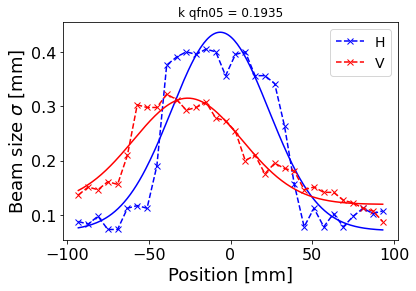

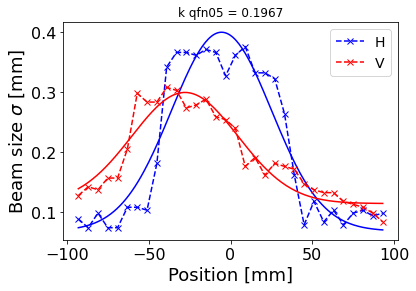

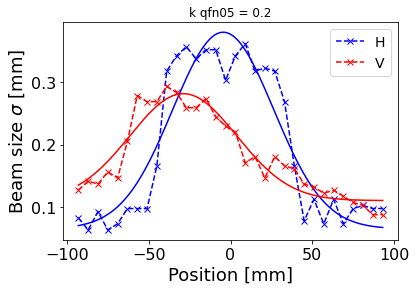

In [37]:
for i in range(len(loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"])):
    fig, ax = plt.subplots()
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    ax.plot(x,y, label="H", color="b", marker="x", ls="--")
    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)
    ax.plot(x2, gaussian_function(x2, popt[0], popt[1], popt[2], popt[3]), color="b")
        
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    ax.plot(x,y, label="V", color="r", marker="x", ls="--")
    popt, pcov = do_gaussian_fit(x, y)
    x2 = np.linspace(-93, 93, 200)
    ax.plot(x2, gaussian_function(x2, popt[0], popt[1], popt[2], popt[3]), color="r")
    ax.legend()
    ax.set_xlabel("Position [mm]", fontsize=18)
    ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
    ax.legend(fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(f"k qfn05 = {round(df.iloc[i].k_qfn05,4)}")

# Let's check the fit that Marcel does because I see 4 times the same beam size

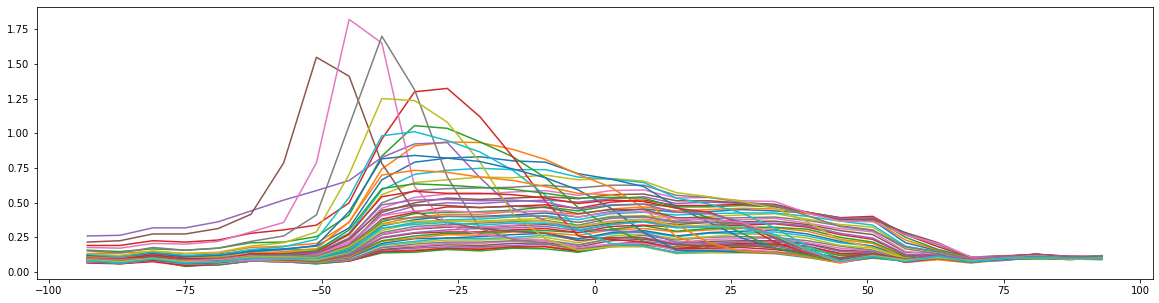

In [38]:
fig, ax = plt.subplots(figsize=(20,5))
for i in range(len(loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'])):
    x = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][i]["HRawProfile"][0]
    y = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][i]["HRawProfile"][1]
    ax.plot(x,y)

    poptH, pcovH = do_gaussian_fit(x, y)
    x2 = np.linspace(0, 192, 200)
#     ax.plot(x2, gaussian_function(x2, poptH[0], poptH[1], poptH[2], poptH[3]))
#     print(f"sigma - sigma_Uccap = {poptH[3]-loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][i]['HSigma']}")

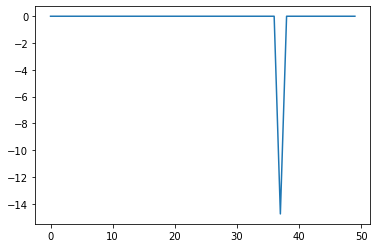

In [39]:
fig, ax = plt.subplots()
my_list = []
for i in range(len(loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'])):
    x = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][i]["HRawProfile"][0]
    y = loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition'][i]["HRawProfile"][1]

    poptH, pcovH = do_gaussian_fit(x, y)
    my_list.append(poptH[3]-loaded_pickle[11]['PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainPositions'][i]['HSigma'])
ax.plot(my_list)

### BLM

In [40]:
blm008=loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence']
blm027=loaded_pickle[9]['F61.BLM008/Acquisition#lossBeamPresence']
blm002=loaded_pickle[9]['F62.BLM002/Acquisition#lossBeamPresence']
blm003=loaded_pickle[9]['F63.BLM003/Acquisition#lossBeamPresence']
blm006=loaded_pickle[9]['T08.BLM006/Acquisition#lossBeamPresence']
blm023=loaded_pickle[9]['T08.BLM023/Acquisition#lossBeamPresence']
blm045=loaded_pickle[9]['T08.BLM045/Acquisition#lossBeamPresence']
blm060=loaded_pickle[9]['T08.BLM060/Acquisition#lossBeamPresence']
blm067=loaded_pickle[9]['T08.BLM067/Acquisition#lossBeamPresence']

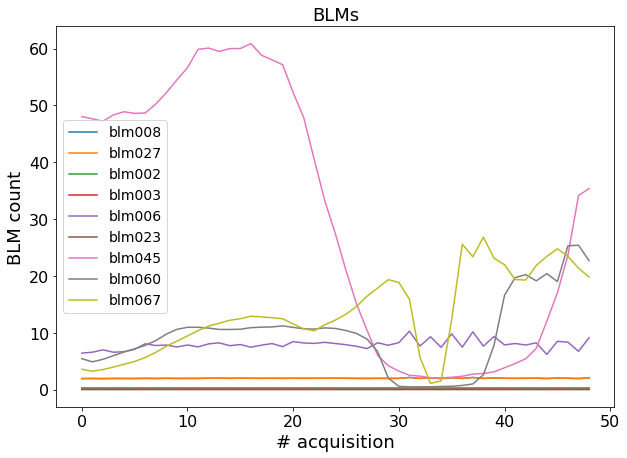

In [41]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(blm008, label="blm008")
ax.plot(blm027, label="blm027")
ax.plot(blm002, label="blm002")
ax.plot(blm003, label="blm003")
ax.plot(blm006, label="blm006")
ax.plot(blm023, label="blm023")
ax.plot(blm045, label="blm045")
ax.plot(blm060, label="blm060")
ax.plot(blm067, label="blm067")
# ax.set_ylim(0,4)
ax.set_xlabel("# acquisition", fontsize=18)
ax.set_ylabel("BLM count", fontsize=18)
ax.set_title("BLMs", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)

### XSEC

In [42]:
xsec023_I1 = loaded_pickle[10]['F61.XSEC023-I1/Acquisition#semNormData']
xsec023_I2= loaded_pickle[10]['F61.XSEC023-I2/Acquisition#semNormData']
xsec070 = loaded_pickle[10]['T08.XSEC070-I/Acquisition#semNormData']
xsec094 = loaded_pickle[10]['T08.XSEC094-I/Acquisition#semNormData']

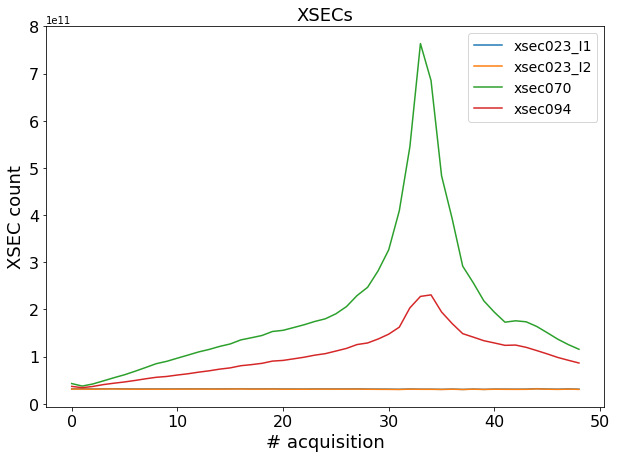

In [43]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(xsec023_I1, label="xsec023_I1")
ax.plot(xsec023_I2, label="xsec023_I2")
ax.plot(xsec070, label="xsec070")
ax.plot(xsec094, label="xsec094")
ax.legend()
ax.set_xlabel("# acquisition", fontsize=18)
ax.set_ylabel("XSEC count", fontsize=18)
ax.set_title("XSECs", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)

## BPM

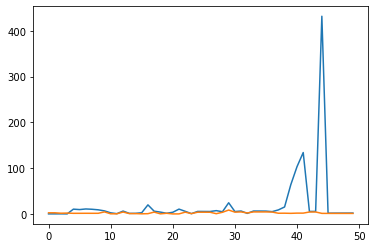

In [44]:
fig, ax = plt.subplots()
ax.plot(df.bpm01H)
ax.plot(df.bpm01V)

#### BPM01

In [45]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.bpm073"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

Text(0.5, 1.0, 'BPM01 quadrupole scan')

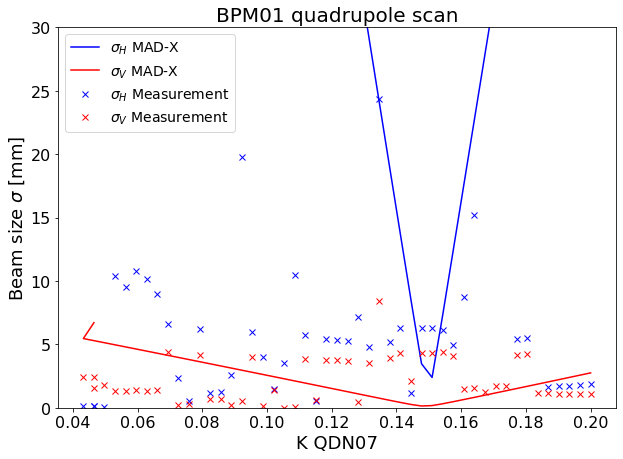

In [46]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qfn05, np.array(HSigma_madx)*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05, np.array(VSigma_madx)*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qfn05, df.bpm01H, color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qfn05, df.bpm01V, color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("BPM01 quadrupole scan", fontsize=20)

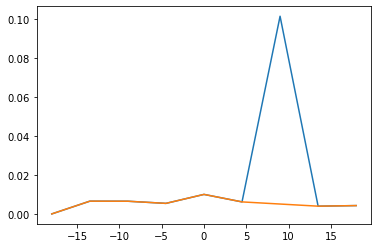

In [47]:
i = 0
fig, ax = plt.subplots()
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
ax.plot(x,y)
x = np.delete(x, 6)
y = np.delete(y, 6)
ax.plot(x,y)

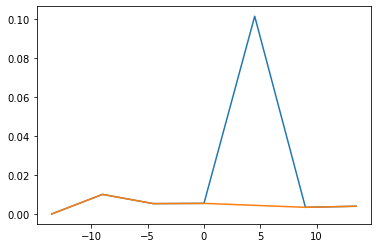

In [48]:
i = 0
fig, ax = plt.subplots()
x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
ax.plot(x,y)
x = np.delete(x, 4)
y = np.delete(y, 4)
ax.plot(x,y)

In [49]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 2

for i in range(len(loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 6)
    y = np.delete(y, 6)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

/tmp/ipykernel_1456/1862854246.py:21: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcovH))[3] < error_threshold:
/tmp/ipykernel_1456/1862854246.py:58: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1456/1862854246.py:78: RuntimeWarning: invalid value encountered in sqrt
  if np.sqrt(np.diag(pcov))[3] < error_threshold:
/tmp/ipykernel_1456/3809438527.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_1456/3809438527.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return a + I / np.sqrt(2 * np.pi

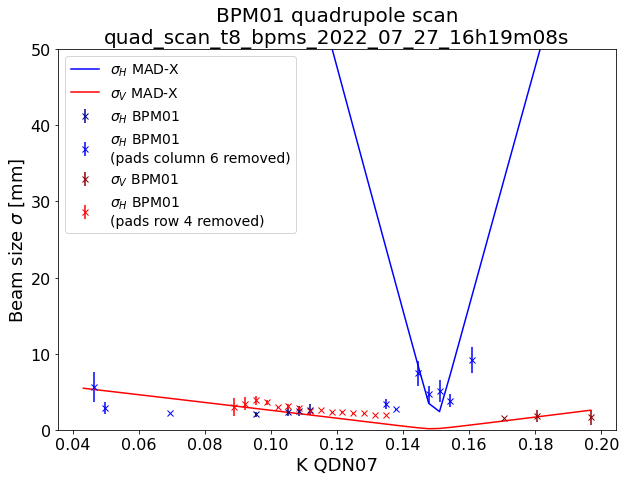

In [50]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qfn05[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.errorbar(df.k_qfn05[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="darkblue", marker="x", ls="", label="$\sigma_{H}$ BPM01")
ax.errorbar(df.k_qfn05[1:-1], np.array(HSigma_refit_pts_removed[1:-1]), HSigma_err_pts_removed[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads column 6 removed)")
ax.errorbar(df.k_qfn05[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="darkred",marker="x", ls="", label="$\sigma_{V}$ BPM01")
ax.errorbar(df.k_qfn05[1:-1], np.array(VSigma_refit_pts_removed[1:-1]), VSigma_err_pts_removed[1:-1], color="r", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(pads row 4 removed)")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,50)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"BPM01 quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/bpm01_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

### BPM2

In [51]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.bpm080"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

Text(0.5, 1.0, 'BPM02 quadrupole scan')

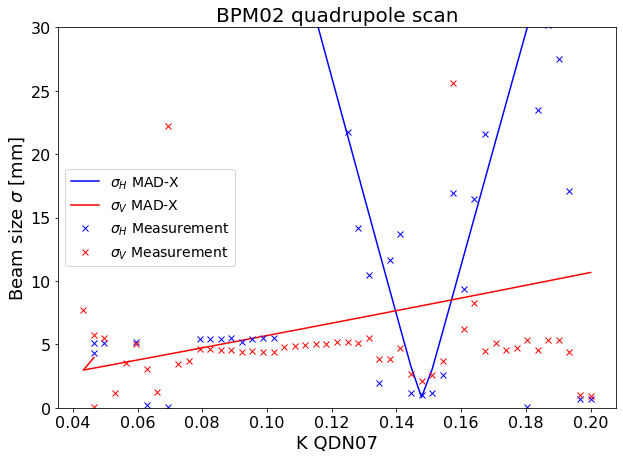

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qfn05, np.array(HSigma_madx)*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05, np.array(VSigma_madx)*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qfn05, df.bpm02H, color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qfn05, df.bpm02V, color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("BPM02 quadrupole scan", fontsize=20)

In [53]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 1

for i in range(len(loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

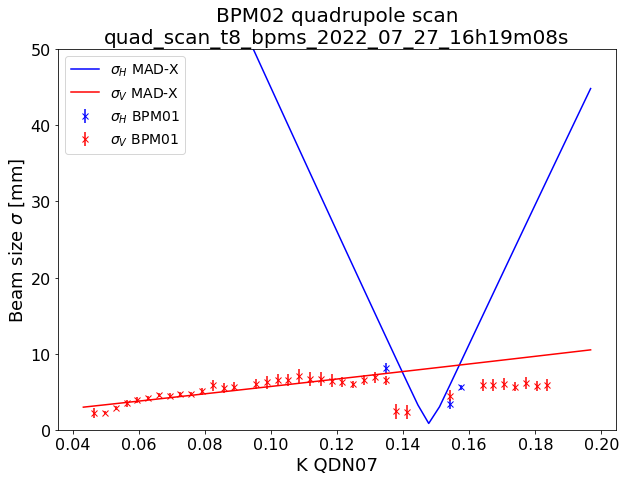

In [54]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qfn05[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.errorbar(df.k_qfn05[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01")
ax.errorbar(df.k_qfn05[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="r",marker="x", ls="", label="$\sigma_{V}$ BPM01")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,50)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"BPM02 quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/bpm02_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

### BPM04

In [55]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/home-e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

# Initial dipole strengths
madx.input("kBHZ1 = -0.044108;")
madx.input("kBHZ2 = 0.045318;")
madx.input("kBHZ3 = 0.022599;")
madx.input("kBHZ4 = -0.03492;")
madx.input("kBHZ5 = -0.038;")

HSigma_madx = []
VSigma_madx = []

instrument_focal_point = "t08.bpm092"
for i in range(len(df)):
    df.iloc[i].k_qfn01
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)

Text(0.5, 1.0, 'BPM04 quadrupole scan')

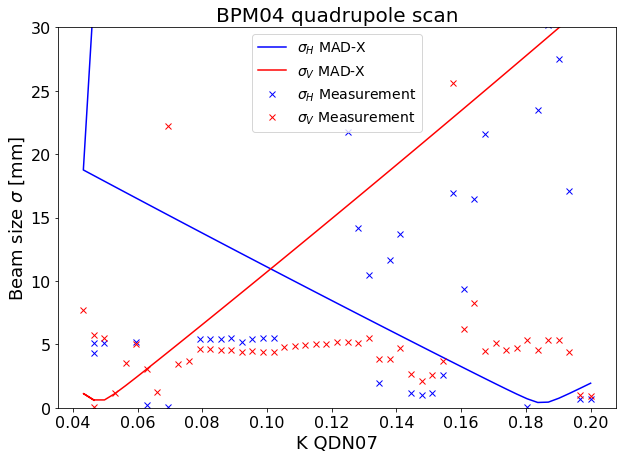

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df.k_qfn05, np.array(HSigma_madx)*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05, np.array(VSigma_madx)*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.plot(df.k_qfn05, df.bpm02H, color="b", marker="x", ls="", label="$\sigma_{H}$ Measurement")
ax.plot(df.k_qfn05, df.bpm02V, color="r", marker="x", ls="", label="$\sigma_{V}$ Measurement")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,30)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title("BPM04 quadrupole scan", fontsize=20)

In [57]:
HSigma_refit = []
HSigma_refit_pts_removed = []
VSigma_refit = []
VSigma_refit_pts_removed = []
HSigma_err = []
HSigma_err_pts_removed = []
VSigma_err = []
VSigma_err_pts_removed = []

error_threshold = 1

for i in range(len(loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"])):
    # Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]

    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit.append(poptH[3])
            HSigma_err.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit.append(np.NaN)
            HSigma_err.append(np.NaN)
    except:
        HSigma_refit.append(np.NaN)
        HSigma_err.append(np.NaN)
    
    # Remove a point in the Horizontal plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        poptH, pcovH = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        if np.sqrt(np.diag(pcovH))[3] < error_threshold:
            HSigma_refit_pts_removed.append(poptH[3])
            HSigma_err_pts_removed.append(np.sqrt(np.diag(pcovH))[3])
        else:
            HSigma_refit_pts_removed.append(np.NaN)
            HSigma_err_pts_removed.append(np.NaN)
    except:
        HSigma_refit_pts_removed.append(np.NaN)
        HSigma_err_pts_removed.append(np.NaN)
    
    # Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit.append(popt[3])
            VSigma_err.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit.append(np.NaN)
            VSigma_err.append(np.NaN)
    except:
        VSigma_refit.append(np.NaN)
        VSigma_err.append(np.NaN)
    
    # Remove a point in the Vertical plane
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    
    try:
        popt, pcov = do_gaussian_fit(x, y)
        x2 = np.linspace(-18, 18, 200)
        # Check on the quality of the fit
        if np.sqrt(np.diag(pcov))[3] < error_threshold:
            VSigma_refit_pts_removed.append(popt[3])
            VSigma_err_pts_removed.append(np.sqrt(np.diag(pcov))[3])
        else:
            VSigma_refit_pts_removed.append(np.NaN)
            VSigma_err_pts_removed.append(np.NaN)
    except:
        VSigma_refit_pts_removed.append(np.NaN)
        VSigma_err_pts_removed.append(np.NaN)

/tmp/ipykernel_1456/3809438527.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_1456/3809438527.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_1456/3809438527.py:2: RuntimeWarning: invalid value encountered in true_divide
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_1456/3809438527.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/tmp/ipykernel_1456/3809438527.py:2: RuntimeWarning: invalid value encountered in multiply
  return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/sit

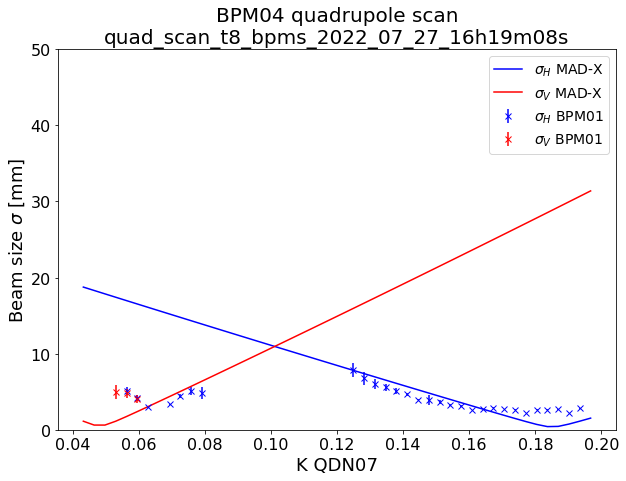

In [58]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df.k_qfn05[1:-1], np.array(HSigma_madx[1:-1])*1000, color="b", label="$\sigma_{H}$ MAD-X")
ax.plot(df.k_qfn05[1:-1], np.array(VSigma_madx[1:-1])*1000, color="r", label="$\sigma_{V}$ MAD-X")
ax.errorbar(df.k_qfn05[1:-1], np.array(HSigma_refit[1:-1]), HSigma_err[1:-1], color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01")
# ax.errorbar(df.k_qfn05, np.array(HSigma_refit_pts_removed), HSigma_err_pts_removed, color="b", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(central pads removed)")
ax.errorbar(df.k_qfn05[1:-1], np.array(VSigma_refit[1:-1]), VSigma_err[1:-1], color="r",marker="x", ls="", label="$\sigma_{V}$ BPM01")
# ax.errorbar(df.k_qfn05, np.array(VSigma_refit_pts_removed), VSigma_err_pts_removed, color="r", marker="x", ls="", label="$\sigma_{H}$ BPM01\n(central pads removed)")
# ax.set_xlim(-0.1, -0.045)
ax.set_ylim(0,50)
ax.set_xlabel("K QDN07", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"BPM04 quadrupole scan\n{subset_dirnames[0]}", fontsize=20)
plt.savefig("fig/bpm04_quad_scan_"+str(subset_dirnames[0])+".png", dpi=300, format=None, metadata=None,
        bbox_inches="tight", transparent = False)

# Gif of the BLM as a function of beam size

<IPython.core.display.Javascript object>


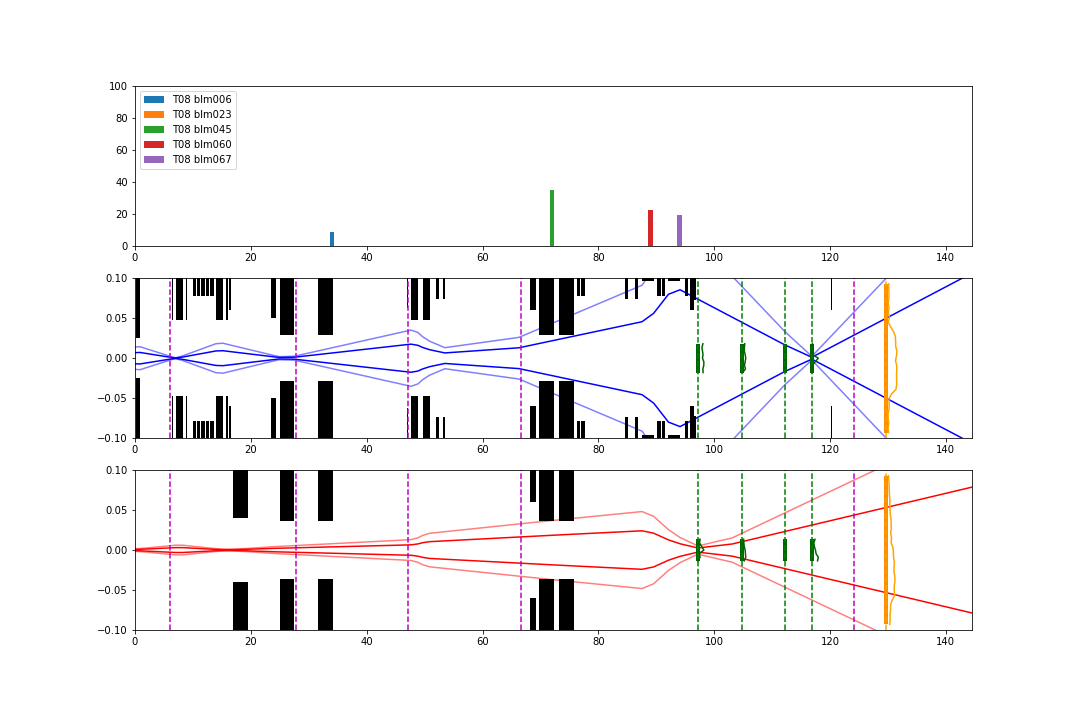

In [59]:
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
fig,ax = plt.subplots(3,1, figsize=(15,10))
def animate(i):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()

    ax[0].bar(34, blm006[i], label="T08 blm006")
    ax[0].bar(50, blm023[i], label="T08 blm023")
    ax[0].bar(72, blm045[i], label="T08 blm045")
    ax[0].bar(89, blm060[i], label="T08 blm060")
    ax[0].bar(94, blm067[i], label="T08 blm067")

    ax[0].legend(loc="upper left")
    ax[0].set_ylim(0,100)
    ax[0].set_xlim(0, 144.5)
    ax[1].set_xlim(0, 144.5)
    ax[2].set_xlim(0, 144.5)
    
    # Computed quad strength with values from 2021-11-12
    madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
    madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
    madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
    madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
    madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
    madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
    madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
    madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
    x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
    y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
    HSigma_madx.append(x_beam_size)
    VSigma_madx.append(y_beam_size)


    draw_aperture(ax[1], twiss_f61, 'aper_1')
    ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b", zorder=0)
    ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b", zorder=0)
    ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
    ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
    
    ax[1].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[1].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

    ax[1].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[1].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[1].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[1].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[1].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["HRawProfile"][1]
    x = np.delete(x, 6)
    y = np.delete(y, 6)
    ax[1].plot(np.array(y)*50 + twiss_f61['s']["t08.bpm073"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["HRawProfile"][1]
    ax[1].plot(np.array(y)*50 + twiss_f61['s']["t08.bpm080"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["HRawProfile"][1]
    ax[1].plot(np.array(y)*50 + twiss_f61['s']["t08.bpm092"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
    ax[1].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)/1000, color="orange")
    
    ax[1].set_ylim(-0.1, 0.1)
    
    draw_aperture(ax[2], twiss_f61, 'aper_2')
    ax[2].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r", zorder=0)
    ax[2].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r", zorder=0)
    ax[2].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r", zorder=0)
    ax[2].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r", zorder=0)
    ax[2].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
    ax[2].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

    ax[2].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
    ax[2].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
    ax[2].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
    ax[2].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

    ax[2].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")
    
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
    ax[2].add_patch(rect)
    rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
    ax[2].add_patch(rect)
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_01/ProfilesAcquisition"][i]["VRawProfile"][1]
    x = np.delete(x, 4)
    y = np.delete(y, 4)
    ax[2].plot(np.array(y)*50 + twiss_f61['s']["t08.bpm073"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_02/ProfilesAcquisition"][i]["VRawProfile"][1]
    ax[2].plot(np.array(y)*50 + twiss_f61['s']["t08.bpm080"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
    ax[2].plot(np.array(y)*50 + twiss_f61['s']["t08.bpm092"],np.array(x)/1000, color="darkgreen")
    
    x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
    y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
    ax[2].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)/1000, color="orange")
    
    ax[2].set_ylim(-0.1, 0.1)
    
    return
        
ani = FuncAnimation(fig, animate, interval=200, blit=True, repeat=False, frames=len(blm008))
ani.save("gif/quad_scan_focal_bpm1.gif", dpi=100, writer=PillowWriter(fps=5))

<IPython.core.display.Javascript object>


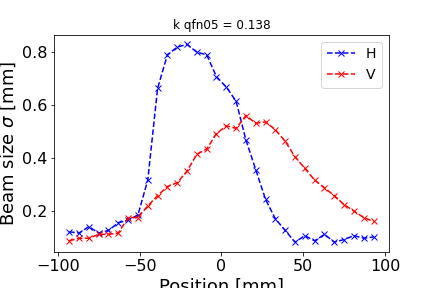

Text(0.5, 1.0, 'k qfn05 = 0.138')

In [60]:
fig, ax = plt.subplots()
i=30
x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
ax.plot(x,y, label="H", color="b", marker="x", ls="--")
# popt, pcov = do_gaussian_fit(x, y)
# x2 = np.linspace(-93, 93, 200)
# ax.plot(x2, gaussian_function(x2, popt[0], popt[1], popt[2], popt[3]), color="b")

x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
ax.plot(x,y, label="V", color="r", marker="x", ls="--")
# popt, pcov = do_gaussian_fit(x, y)
# x2 = np.linspace(-93, 93, 200)
# ax.plot(x2, gaussian_function(x2, popt[0], popt[1], popt[2], popt[3]), color="r")

ax.legend()
ax.set_xlabel("Position [mm]", fontsize=18)
ax.set_ylabel("Beam size $\sigma$ [mm]", fontsize=18)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_title(f"k qfn05 = {round(df.iloc[i].k_qfn05,4)}")

<IPython.core.display.Javascript object>


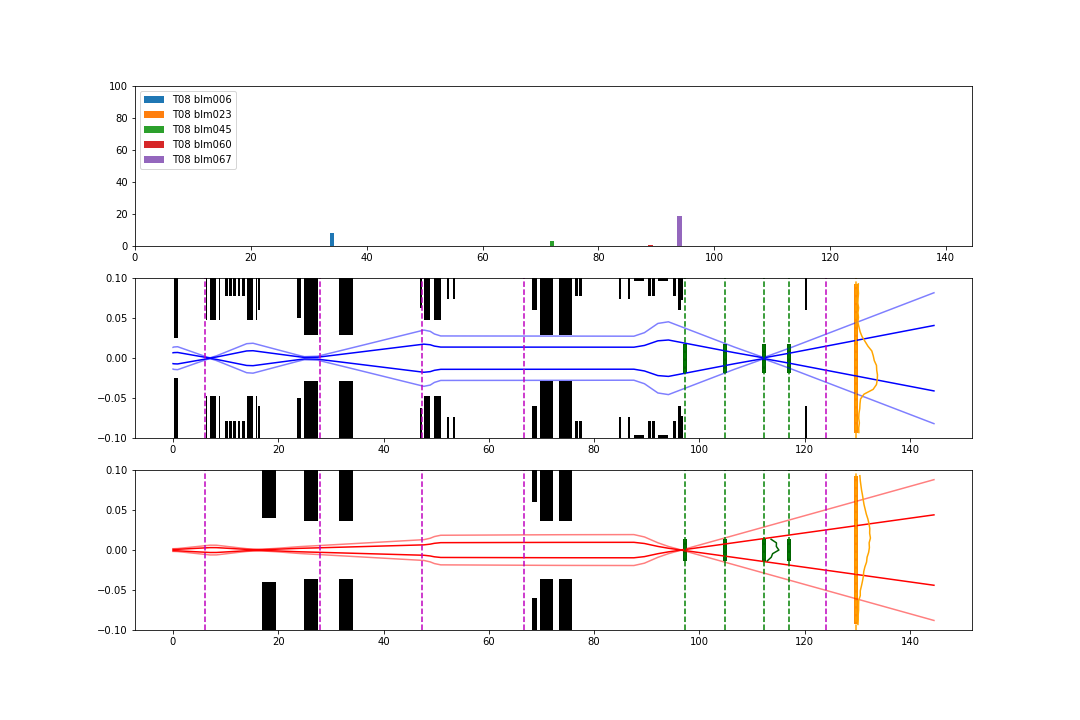

(-0.1, 0.1)

In [61]:
fig,ax = plt.subplots(3,1, figsize=(15,10))

i=30
ax[0].clear()
ax[1].clear()
ax[2].clear()

ax[0].bar(34, blm006[i], label="T08 blm006")
ax[0].bar(50, blm023[i], label="T08 blm023")
ax[0].bar(72, blm045[i], label="T08 blm045")
ax[0].bar(89, blm060[i], label="T08 blm060")
ax[0].bar(94, blm067[i], label="T08 blm067")

ax[0].legend(loc="upper left")
ax[0].set_ylim(0,100)
ax[0].set_xlim(0, 144.5)

# Computed quad strength with values from 2021-11-12
madx.input("kQFN1 = "+str(df.iloc[i].k_qfn01)+";")
madx.input("kQDN2 = "+str(df.iloc[i].k_qdn02)+";")
madx.input("kQFN3 = "+str(df.iloc[i].k_qfn03)+";")
madx.input("kQDN4 = "+str(df.iloc[i].k_qdn04)+";")
madx.input("kQFN5 = "+str(df.iloc[i].k_qfn05)+";")
madx.input("kQDN6 = "+str(df.iloc[i].k_qdn06)+";")
madx.input("kQDN7 = "+str(df.iloc[i].k_qdn07)+";")
madx.input("kQFN8 = "+str(df.iloc[i].k_qfn08)+";")
twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file = "twiss_f61.tfs").dframe()
x_beam_size = beam_size(twiss_f61['betx'][instrument_focal_point], twiss_f61['dx'][instrument_focal_point], ex, sige, 1)
y_beam_size = beam_size(twiss_f61['bety'][instrument_focal_point], twiss_f61['dy'][instrument_focal_point], ey, sige, 1)
HSigma_madx.append(x_beam_size)
VSigma_madx.append(y_beam_size)

# Horizontal plane
draw_aperture(ax[1], twiss_f61, 'aper_1')
ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b")
ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 2), alpha=0.5, color ="b")
ax[1].plot(twiss_f61['s'], beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b")
ax[1].plot(twiss_f61['s'], -beam_size(twiss_f61['betx'], twiss_f61['dx'], ex, sige, 1), alpha=1.0, color ="b")

ax[1].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
ax[1].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
ax[1].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
ax[1].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
ax[1].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

ax[1].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
ax[1].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
ax[1].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
ax[1].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

ax[1].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")

rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[1].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[1].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[1].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.018), 0.0 , 0.018*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[1].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
ax[1].add_patch(rect)

x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][0]
y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["HRawProfile"][1]
ax[1].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)/1000, color="orange")

ax[1].set_ylim(-0.1, 0.1)

# Vertical plane
draw_aperture(ax[2], twiss_f61, 'aper_2')
ax[2].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r")
ax[2].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 2), alpha=0.5, color ="r")
ax[2].plot(twiss_f61['s'], beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r")
ax[2].plot(twiss_f61['s'], -beam_size(twiss_f61['bety'], twiss_f61['dy'], ey, sige, 1), color ="r") 
ax[2].axvline(twiss_f61.s["f61.btv012"], linestyle = "--", color = "m")
ax[2].axvline(twiss_f61.s["f62.btv002"], linestyle = "--", color = "m")
ax[2].axvline(twiss_f61.s["t08.btv020"], linestyle = "--", color = "m")
ax[2].axvline(twiss_f61.s["t08.btv035"], linestyle = "--", color = "m")
ax[2].axvline(twiss_f61.s["t08.btv096"], linestyle = "--", color = "m")

ax[2].axvline(twiss_f61.s["t08.bpm073"], linestyle = "--", color = "g")
ax[2].axvline(twiss_f61.s["t08.bpm080"], linestyle = "--", color = "g")
ax[2].axvline(twiss_f61.s["t08.bpm085"], linestyle = "--", color = "g")
ax[2].axvline(twiss_f61.s["t08.bpm092"], linestyle = "--", color = "g")

ax[2].axvline(twiss_f61.s["t08.xwcm103"], linestyle = "--", color = "orange")

rect = patches.Rectangle((twiss_f61['s']["t08.bpm073"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[2].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.bpm080"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[2].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.bpm085"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[2].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.bpm092"], -0.0135), 0.0 , 0.0135*2, linewidth=4, edgecolor='darkgreen', facecolor='none')
ax[2].add_patch(rect)
rect = patches.Rectangle((twiss_f61['s']["t08.xwcm103"], -0.093), 0.0 , 0.093*2, linewidth=4, edgecolor='darkorange', facecolor='none')
ax[2].add_patch(rect)

x = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][0]
y = loaded_pickle[8]["PS-LOG-BPM-IRRAD-UCAP_BPM_04/ProfilesAcquisition"][i]["VRawProfile"][1]
ax[2].plot(np.array(y)*50 + twiss_f61['s']["t08.bpm085"],np.array(x)/1000, color="darkgreen")

x = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][0]
y = loaded_pickle[11]["PS-LOG-MWPC-UCAP_IRRAD_2080/LowGainProfilesAcquisition"][i]["VRawProfile"][1]
ax[2].plot(np.array(y)*5 + twiss_f61['s']["t08.xwcm103"],np.array(x)/1000, color="orange")

ax[2].set_ylim(-0.1, 0.1)

<IPython.core.display.Javascript object>


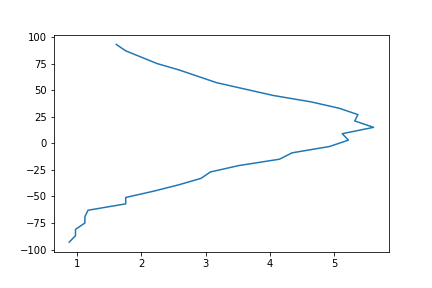

In [62]:
fig, ax = plt.subplots()
ax.plot(np.array(y)*10,x)